# Direct Solve approach to the coding exercise from 06Feb2020

__Note:__ The problem is from "coding_06Feb" and the solutions through 2c are in "coding_help.ipynb". Here we implement and apply the direct solve method.

Instead of stepping, we set up a system of simultaneous equations (one for each node on the discretized grid) and solve the system of equations for the full solution.

In [442]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [443]:
import numpy as np
from diy_ode import *
from simple_plot import *
np.set_printoptions(precision=2)

Consider the boundary value problem (BVP) consisting of the differential equation $$\frac{d^2 y}{dx^2} +x \frac{dy}{dx} + \beta y = 0$$
with boundary conditions $$y'(0)=0, \; y(1)=0$$

0) Classify the equation before doing any computing. Can you write an analytical solution for this equation?

__Linearity let's us choose $y(0)=1$__ to go along with $y'(0)=0$ for initial conditions (ICs).

1) Use an ODE solver to compute solutions for a few values of $\beta$. Plot your results and inspect to get a feel for how the solution behave.

Find the first 4 eigenvalues and eigenfunctions in 3 different ways:

2a) Use an ODE solver to compute solutions for a few values of $\beta$. Plot your results and inspect to get a feel for how the solutions behave.

2b) Use the shooting method based on your Runge-Kutta code.

2c) Use the shooting method based on the `solve_ivp` library function.

3) Use the direct solve method with an eigensolver from the linear algebra library.

If you breezed through the items above, try this one:

4b) Consider the ODE $$\frac{d}{dx} \big[ (1-x^2) \frac{dy}{dx} \big] + \lambda y = 0$$ with boundary conditions $$y'(0)=0, y(1)=0$$

Here we take on Problem 3. Following the presentation Ch. 7, we implement the direct solve approach as follows:

1) Discretize the domain to a uniform grid with `n` nodes

In [444]:
L = 1 #length of domain
n = 8 #number of internal nodes  to solved for on the grid
n_total = n + 2 #number of nodes including a boundary node at each end
dx = L/(n_total - 2)
x_full = np.linspace(0,1,n_total-1)
x = x_full[1:-1] #x values at internal nodes
x

array([0.12, 0.25, 0.38, 0.5 , 0.62, 0.75, 0.88])

2) Use the finite difference approximation for each derivative as a __stencil__ to rewrite the value of each derivative at a generic point as a linear combination of the values of $y$ at the point and its neighbors. The central difference approximation for the first derivative is:
$$ \frac{dy}{dx} = \frac{1}{2 \Delta x} (- y_{i-1} + 0 y_i +1 y_{i+1})$$
Applying the central difference at each internal node of the grid gives:

\begin{equation}
\frac{d\boldsymbol{y}}{dx} =
\frac{1}{2 \Delta x}
\begin{bmatrix}
   0 y_0 &+1 y_1 &+0 y_2 &+ 0 y_3 &+ 0 y_4 &+ \ldots \\
   -1 y_0 &+0 y_1 &+1 y_2 &+0 y_3 &+ 0 y_4 &+ \ldots  \\
   0 y_0 &-1 y_1 &+0 y_2 &+1 y_3 &+ 0 y_4 &+ \ldots \\
   0 y_0 &+0 y_1 &-1 y_2 &+0 y_3 &+1 y_4 &+ \ldots \\
   \vdots   
\end{bmatrix}
+ \frac{1}{2 \Delta x}
\begin{bmatrix}
   -y_{-1} \\
   0  \\
   0 \\
   0 \\
   \vdots 
\end{bmatrix}
\end{equation}

which can be written in matrix-vector form as:

\begin{equation}
\frac{d\boldsymbol{y}}{dx} =
\frac{1}{2 \Delta x}
\begin{bmatrix}
   0 &1  &0 & 0 & 0 & \ldots \\
   -1 &0 &1 &0 & 0 & \ldots  \\
   0  &-1  &0 &1  & 0 & \ldots \\
   0 &0  &-1  &0  &1  & \ldots \\
   \vdots   
\end{bmatrix}
\begin{bmatrix}
   y_0 \\
   y_1  \\
   y_2 \\
   y_3 \\
   \vdots 
\end{bmatrix}
+ \frac{1}{2 \Delta x}
\begin{bmatrix}
   -y_{-1} \\
   0  \\
   0 \\
   0 \\
   \vdots 
\end{bmatrix}
\end{equation}

So the $1^{st}$ derivative in the ODE converts to a multiple ($\frac{1}{2 \Delta x}$) of a matrix with 1's just above the main diagonal and -1's just below the main diagonal. 

Now let's write some code to construct this matrix given the grid specifications. Let's start by writing a function `d1` to construct the basic matrix for Dirichlet BCs. (We'll insert the $\frac{1}{2 \Delta x}$ factor later.)

In [445]:
def d1(n):
    '''
    construct 2D numpy array corr. to nxn matrix version of central difference operator for 1st derivative (homogenous Dirichlet BCs)
    
    Args:
        n: integer size of array (number of nodes at which to solve)
        
    Returns:
        a: nxn numpy array with 1 on diagonal above main diagonal and -1 on diagonal below main diagonal
    '''
    #insert your code here
    return a

Let's test the function to see if it produces the desired result:

In [414]:
d1(n)

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.]])

That looks good, but let's note that this array can also be constructed with a standard function, `diags`, from the sparse matrix package `scipy.sparse`.

In [446]:
from scipy.sparse import diags

def d1_sparse(n):
    '''
    construct nxn sparse matrix version of central difference operator for 1st derivative (homogenous Dirichlet BCs)
    
    Args:
        n: integer size of array (number of nodes at which to solve
        
    Returns:
        sp: nxn numpy sparse array with 1 on diagonal above main diagonal and -1 on diagonal below main diagonal   
    '''
    #insert your code here
    return sp

Again, let's test the function:

In [447]:
d1_sparse(n)

(<8x8 sparse matrix of type '<class 'numpy.float64'>'
 	with 22 stored elements (3 diagonals) in DIAgonal format>,
 scipy.sparse.dia.dia_matrix)

This, like most sparse matrix representations, aims for effieciency in terms of memory usage and processing speed; readability by humans is not a goal. To get a version that we can make sense of, use the `toarray()` method that comes built-in with all Scipy sparse matrices.

In [417]:
d1_sparse(n).toarray()

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.]])

Now let's do likewise for the $2^{nd}$ derivative based on the centered difference approximation 
$$\frac{d^2 y}{dx^2} = \frac{1}{\Delta x^2} (1 y_{i-1} -2 y_i +1 y_{i+1})$$

Again, code it up and test (again planning to include the factor of $\frac{1}{\Delta x^2}$ at the end):

In [418]:
def d2(n):
    '''
    construct 2D numpy array corr. to nxn matrix version of central difference operator for 2nd derivative (homogenous Dirichlet BCs)
    
    Args:
        n: integer size of array (number of nodes at which to solve)
        
    Returns:
        a: nxn numpy array with -2 on main diagonal and 1 on diagonals above and below main diagonal
    '''
    #insert your code here
    return a 

In [419]:
d2(n)

array([[-2.,  1., -0., -0., -0., -0., -0., -0.],
       [ 1., -2.,  1., -0., -0., -0., -0., -0.],
       [-0.,  1., -2.,  1., -0., -0., -0., -0.],
       [-0., -0.,  1., -2.,  1., -0., -0., -0.],
       [-0., -0., -0.,  1., -2.,  1., -0., -0.],
       [-0., -0., -0., -0.,  1., -2.,  1., -0.],
       [-0., -0., -0., -0., -0.,  1., -2.,  1.],
       [-0., -0., -0., -0., -0., -0.,  1., -2.]])

Looks good, but let's consider the sparse version again:

In [420]:
def d2_sparse(n):
    '''
    construct nxn sparse matrix version of central difference operator for 1st derivative (homogenous Dirichlet BCs)
    
    Args:
        n: integer size of array (number of nodes at which to solve
        
    Returns:
        sp: nxn numpy sparse array with 1 on diagonal above main diagonal and -1 on diagonal below main diagonal   
    '''
    #insert your code here
    return sp

In [421]:
d2_sparse(n).toarray()

array([[-2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1., -2.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1., -2.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1., -2.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1., -2.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1., -2.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1., -2.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -2.]])

3) Make adjustments as necessary to account for boundary conditions.

Using central differences, the first and last equations would involve values at or beyond the end of the computational grid. 

- If we have homogeneous Dirichlet BCs (i.e. $y = 0$ on the boundary), those boundary contributions vanish, and the matrix is fine as it is. 

- For periodic boundary conditions, $y_0 \equiv y_n$, we change the upper-rightmost entry from 0 to -1 and the lower-leftmost  entry from 0 to 1.

- For Neumann BCs ($y'(0)=0)$, we apply the forward difference formula (instead of central difference). Note that the value at the boundary will not be explicitly included as part of the eigenvalue problem, so let's label that value as $y_{-1}$ so we can employ our usual indexing (starting at 0) in the computational domain. The forward difference approach to finding $y_{-1}$ goes as follows:

$$y_0 = y_{-1} + \Delta x y'_{-1} + (\Delta x)^2 \frac{1}{2}y''_{-1} + \ldots$$

$$y_1 = y_{-1} + 2 \Delta x y'_{-1} + (2 \Delta x)^2 \frac{1}{2}y''_{-1} + \ldots$$
<br>To cancel out the terms of order $O(\Delta x^2)$, multiply the first equation by 4 and subtract the second to obtain:

$$4 y_0 - y_1 = (4-1) y_{-1} + (4-2) (\Delta x) \, y'_{-1}$$
<br>which we can solve for the $2^{nd}$ order forward difference estimate of the $1^{st}$ derivative:

$$\frac{dy}{dx} = \frac{1}{2 \Delta x} (-3 y_{-1} + 4 y_0 - 1 y_1)$$

$$\frac{dy}{dx} = 0 \rightarrow y_{-1} = (\frac{4}{3} y_0 - \frac{1}{3} y_1)$$

This equation will be used to compute the value of $y_0$ that satisfies $y'(0)=0$.

We also plug it into the central difference approximation of $y'_0$:

$$ \frac{dy_0}{dx} = \frac{1}{2 \Delta x} ( y_1 - y_{-1}) = \frac{1}{2 \Delta x} (-\frac{4}{3} y_0 + \frac{4}{3} y_1)$$
<br>The bottom line is that imposing the Neumann BC ($y'(0)=0$) involes 2 steps:

- Adjust the first row of the matrix from $[0,1,0, \ldots ,0]$ to $[4/3, -4/3, 0, \ldots, 0]$.

- Prepend (4*y[0] - y[1])/3 to the left end of the eigenvector.

We can now write a function to produce the appropriate array. 

The name `d1_nd` indicates that the array provides the discrete analog of the $1^{st}$ derivative with Neumann BC on the left and Dirichlet BC on the right:

In [422]:
def d1_nd(n):
    a = d1(n)
    a[0,0], a[0,1] = -4/3, 4/3
    return a

In [423]:
print(d1_nd(n))

[[-1.33  1.33  0.    0.    0.    0.    0.    0.  ]
 [-1.    0.    1.    0.    0.    0.    0.    0.  ]
 [ 0.   -1.    0.    1.    0.    0.    0.    0.  ]
 [ 0.    0.   -1.    0.    1.    0.    0.    0.  ]
 [ 0.    0.    0.   -1.    0.    1.    0.    0.  ]
 [ 0.    0.    0.    0.   -1.    0.    1.    0.  ]
 [ 0.    0.    0.    0.    0.   -1.    0.    1.  ]
 [ 0.    0.    0.    0.    0.    0.   -1.    0.  ]]


This also looks good. Now adjust for a left Neumann BC based on the forward difference approximation of the $2^{nd}$ derivative:

$$ \frac{d^2y_0}{dx^2} = \frac{1}{\Delta x^2} (y_{-1} -2 y_0 +y_1) = \frac{1}{\Delta x^2} (\frac{4}{3} y_0 - \frac{1}{3} y_1 -2 y_0 +y_1) = \frac{1}{\Delta x^2} (-\frac{2}{3} y_0 + \frac{2}{3} y_1) $$

Thus the adjustment of the $2^{nd}$ derivative matrix to account for the homogeneous Neumann BC at the left end is to replace the first row with `[-2/3, 2/3, 0, ... ,0]`. The function `d2_nd` produces the corresponding nxn array with left Neumann BC and right Dirchlet BC (with the $\frac{1}{\Delta x^2}$ factor to be included later):

In [426]:
def d2_nd(n):
    '''
    construct 2D numpy array corr. to nxn matrix version of central difference operator for 1st derivative
    BCs: homogeneous Neumann at left end and homogenous Dirichlet at right end
    
    Args:
        n: integer size of array (number of nodes at which to solve)
        
    Returns:
        a: nxn numpy array with 1 on diagonal above main diagonal and -1 on diagonal below main diagonal
            a[0,0] = -2/3, a[0,1] = 2/3 to account for zero slope at left end
    '''
    a = d2(n)
    a[0,0], a[0,1] = -2/3, 2/3
    return a

In [427]:
d2_nd(n)

array([[-0.67,  0.67, -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ],
       [ 1.  , -2.  ,  1.  , -0.  , -0.  , -0.  , -0.  , -0.  ],
       [-0.  ,  1.  , -2.  ,  1.  , -0.  , -0.  , -0.  , -0.  ],
       [-0.  , -0.  ,  1.  , -2.  ,  1.  , -0.  , -0.  , -0.  ],
       [-0.  , -0.  , -0.  ,  1.  , -2.  ,  1.  , -0.  , -0.  ],
       [-0.  , -0.  , -0.  , -0.  ,  1.  , -2.  ,  1.  , -0.  ],
       [-0.  , -0.  , -0.  , -0.  , -0.  ,  1.  , -2.  ,  1.  ],
       [-0.  , -0.  , -0.  , -0.  , -0.  , -0.  ,  1.  , -2.  ]])

We can now cast this system in the form of an eigenvlue problem, $A y = \beta y$, by isolating the last term in the equation and replacing the derivative terms with their discrete counterparts according to:

$- \frac{d^2}{dx^2} - x \frac{d}{dx} \rightarrow \qquad $`A = -d2_nd(n)/(dx**2) - x*d1_nd(n)/(2*dx)`

4) Having coded up the basic difference arrays appropriate for the BCs, we can now construct the full array comprising the discrete version of the problem:

In [431]:
from numpy import linalg as LA

#reinitialize with finer grid
L = 1 #length of domain
n = 20 #number of internal nodes  to solved for on the grid
n_total = n + 2 #number of nodes including a boundary node at each end
dx = L/(n_total - 1)
x_full = np.linspace(0,1,n_total)
x = x_full[1:-1] #x values at internal nodes

#insert code here to construct the matrix corr. to d**2/dx**2 + x* d/dx
A

array([[ 294.67, -295.33,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,
           0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,
           0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ],
       [-440.5 ,  882.  , -442.5 ,    0.  ,    0.  ,    0.  ,    0.  ,
           0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,
           0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ],
       [   0.  , -440.  ,  882.  , -443.  ,    0.  ,    0.  ,    0.  ,
           0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,
           0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ],
       [   0.  ,    0.  , -439.5 ,  882.  , -443.5 ,    0.  ,    0.  ,
           0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,
           0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ],
       [   0.  ,    0.  ,    0.  , -439.  ,  882.  , -444.  ,    0.  ,
           0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,
           0.  ,    0.  ,    0.  ,    

As arrays get larger, it gets difficult to see the structure so there are functions for visualizing matrices. <br>`spy` shows non-zero entries in a matrix.<br>`matshow` shades based on the values in the matrix.

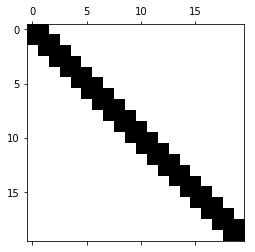

In [432]:
plt.spy(A)

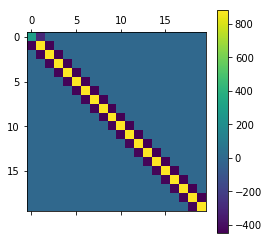

In [433]:
mat = plt.matshow(A)
plt.colorbar(mat)

5) Finally, we compute the eigenvalues and eigenvectors using `eig` from the linear algebra package `linalg`. Visit the documentation page for `eig` and look at what it returns (and the examples at the bottom) to understand why the results are assigned to a 2-tuple and that the eigenvector associated with `vals[i]` is `vecs[:,i]`.

In [441]:
#insert code here to compute eigenvalues and eigenvectors

vals #display the eigenvalues

array([   2.05,   21.78,   60.83,  118.54,  193.84,  285.19,  390.65,
        507.89,  634.21,  766.66,  902.12, 1037.34, 1753.83, 1722.29,
       1670.59, 1600.  , 1512.23, 1169.07, 1409.44, 1294.11])

So now we have eigenvalues, but the eigenvectors are missing the end values at the boundaries. Let's fix that by padding each eigenvector with a zero on the right and using the forward difference formula on the left: $y_{-1} = (4 y_0 - y_1)/3$

In [435]:
vecs[:,0]

array([-0.32, -0.32, -0.32, -0.31, -0.3 , -0.29, -0.28, -0.26, -0.24,
       -0.23, -0.21, -0.19, -0.17, -0.15, -0.12, -0.1 , -0.08, -0.06,
       -0.04, -0.02])

In [438]:
#insert code here to padd the eigenvector with zero slope at left end and zero value at right end
def pad(v):
    '''
    pad eigenvectors according to BCs
    
    Args:
        v: computed eigenvector of length n
        
    Returns:
        vec: padded eigenvector length n+2 satisfying "nd" BCs
    '''
    return vec

full_vecs = np.apply_along_axis(pad, 0, vecs)

In [439]:
full_vecs[:,0]

array([ 1.  ,  1.  ,  0.99,  0.97,  0.95,  0.92,  0.89,  0.85,  0.8 ,
        0.75,  0.7 ,  0.64,  0.58,  0.51,  0.45,  0.38,  0.32,  0.25,
        0.19,  0.12,  0.06, -0.  ])

Now we can print out the first several eigenvalues and plot the associated eigenfunctions.

Eigenvalues: beta =  [ 2.05 21.78 60.83]


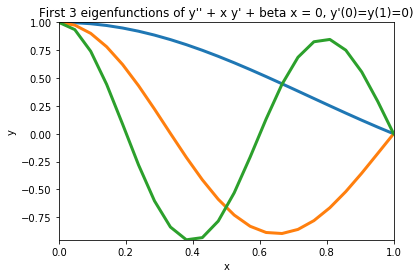

In [440]:
print("Eigenvalues: beta = ", vals[:3])
arrayplot(x_full,full_vecs[:,:3], titlestring="First 3 eigenfunctions of y'' + x y' + beta x = 0, y'(0)=y(1)=0)")

An implementation of the desired code is provided below. Try writing and only read/verify as needed!
<br><br><br><br><br><br><br><br>

In [ ]:
def d1(n):
    a = np.zeros([n,n])
    for i in range(n-1):
        a[i+1,i] = -1
        a[i,i+1] = +1
    return a

from scipy.sparse import diags

def d1_sparse(n):
    return diags([-1,0,1], [-1,0,1],shape=(n,n))

def d2(n):
    a = -2*np.eye(n) #start with a multiple of identity matrix to set the values on the main diagonal
    #assign values adjacent to main diagonal
    for i in range(n-1):
        a[i+1,i] = 1
        a[i,i+1] = 1
    return a 

def d2_sparse(n):
    return diags([1,-2,1], [-1,0,1],shape=(n,n))

def d1_nd(n):
    a = d1(n)
    a[0,0], a[0,1] = -4/3, 4/3
    return a

def d2_nd(n):
    a = d2(n)
    a[0,0], a[0,1] = -2/3, 2/3
    return a

In [ ]:
from numpy import linalg as LA

#reinitialize with finer grid
L = 1 #length of domain
n = 20 #number of internal nodes  to solved for on the grid
n_total = n + 2 #number of nodes including a boundary node at each end
dx = L/(n_total - 1)
x_full = np.linspace(0,1,n_total)
x = x_full[1:-1] #x values at internal nodes

A = -d2_nd(n)/(dx**2) - x*d1_nd(n)/(2*dx)
A

In [ ]:
vals, vecs = LA.eig(A)

In [ ]:
def pad(v):
    nval = (4*v[0]-v[1])/3
    return np.concatenate([[nval],v,[0]])/nval # divide by nval so eigenfuncs start at 1